In [237]:
# train a generative adversarial network on a one-dimensional function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import tensorflow
tensorflow.test.gpu_device_name()

import numpy
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
#from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU


In [238]:
%matplotlib inline
import matplotlib.pyplot as plt

## Dataset

In [73]:
import scipy.io
# load phase dateset
def load_real_samples():
    d = scipy.io.loadmat('dataset')
    data_X = d['data_X']
    data_Y = d['data_Y'].ravel()
    
    #class abundances
    #print('N:', sum((data_Y == 0).ravel()))
    #print('S:', sum((data_Y == 1).ravel()))
    #print('P:', sum((data_Y == 2).ravel()))
    #print('T:', sum((data_Y == 3).ravel()))
    
    P_phase_indices = (data_Y == 2)
    X = data_X[P_phase_indices]
    
    means_in_channels = numpy.mean(X, axis=1, keepdims=True)
    X -= means_in_channels
    
    max_in_channels = numpy.max(numpy.max(numpy.abs(X), axis=1, keepdims=True), axis=2, keepdims=True)
    
    X /= max_in_channels
    
    return X

(6364, 400, 3)


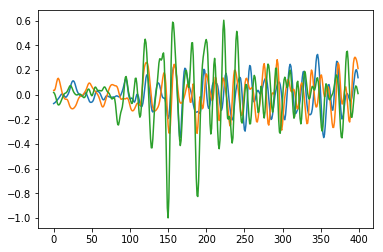

In [149]:
dataset = load_real_samples()
SAMPLES = dataset.shape[1]
CHANNELS = dataset.shape[2]
print(dataset.shape)
plt.plot(dataset[1005])

## Discriminator

In [83]:
# define the standalone discriminator model
def define_discriminator(in_shape=(SAMPLES,CHANNELS)):
    model = Sequential()
    model.add(Conv1D(64, (3,), strides=(2,), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv1D(64, (3,), strides=(2,), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [84]:
# define the discriminator model
model = define_discriminator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 200, 64)           640       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 200, 64)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 100, 64)           12352     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 100, 64)           0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6400)              0         
__________

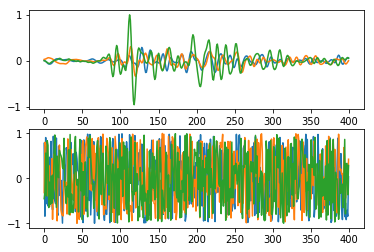

In [153]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = numpy.random.uniform(low=-1., high=1., size=(n_samples, SAMPLES, CHANNELS))
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, SAMPLES, CHANNELS))
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y



X_real, _ = generate_real_samples(dataset, 100)
plt.subplot(211)
plt.plot(X_real[14])


X_fake, _ = generate_fake_samples(100)
plt.subplot(212)
plt.plot(X_fake[14])





In [86]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [87]:
# fit the model
model = define_discriminator()
train_discriminator(model, dataset)

>1 real=51% fake=25%
>2 real=62% fake=37%
>3 real=42% fake=51%
>4 real=29% fake=65%
>5 real=29% fake=82%
>6 real=18% fake=93%
>7 real=12% fake=94%
>8 real=9% fake=97%
>9 real=5% fake=98%
>10 real=7% fake=100%
>11 real=3% fake=99%
>12 real=2% fake=100%
>13 real=1% fake=100%
>14 real=2% fake=100%
>15 real=1% fake=100%
>16 real=1% fake=100%
>17 real=0% fake=100%
>18 real=1% fake=100%
>19 real=0% fake=100%
>20 real=0% fake=100%
>21 real=0% fake=100%
>22 real=1% fake=100%
>23 real=0% fake=100%
>24 real=0% fake=100%
>25 real=0% fake=100%
>26 real=0% fake=100%
>27 real=0% fake=100%
>28 real=1% fake=100%
>29 real=1% fake=100%
>30 real=0% fake=100%
>31 real=0% fake=100%
>32 real=0% fake=100%
>33 real=0% fake=100%
>34 real=0% fake=100%
>35 real=1% fake=100%
>36 real=0% fake=100%
>37 real=1% fake=100%
>38 real=8% fake=100%
>39 real=2% fake=100%
>40 real=1% fake=100%
>41 real=3% fake=100%
>42 real=5% fake=100%
>43 real=6% fake=100%
>44 real=4% fake=100%
>45 real=5% fake=100%
>46 real=7% fake=100%


## Generator

In [142]:
FAKEDIM = 1
CHANNELS = 3

# example of defining the generator model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
#from tensorflow.keras.utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 100 samples (downsampled 400 samples)
    n_nodes = 128 * 100 # 128 is number of possible realizations
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((100, FAKEDIM, 128)))
    # upsample to 200
    model.add(Conv2DTranspose(128, (4,FAKEDIM), strides=(2,FAKEDIM), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 400
    model.add(Conv2DTranspose(128, (4,FAKEDIM), strides=(2,FAKEDIM), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(CHANNELS, (7,FAKEDIM), activation='sigmoid', padding='same'))
    model.add(Reshape((400,3)))
    return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
#plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 12800)             1292800   
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 12800)             0         
_________________________________________________________________
reshape_24 (Reshape)         (None, 100, 1, 128)       0         
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 200, 1, 128)       65664     
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 200, 1, 128)       0         
_________________________________________________________________
conv2d_transpose_43 (Conv2DT (None, 400, 1, 128)       65664     
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 400, 1, 128)       0         
__________

(10, 400, 3)


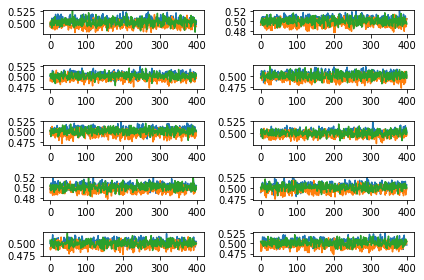

In [158]:
from numpy.random import randn
import matplotlib.pyplot as plt

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 10
X, _ = generate_fake_samples(model, latent_dim, n_samples)

print(X.shape)

# plot the generated samples
for i in range(n_samples):
    # define subplot
    plt.subplot(5, 2, 1 + i)
    # plot single image
    plt.plot(X[i, :, :]) #, :])

plt.tight_layout()
plt.show()

## Define GAN model

In [204]:
from numpy.random import randn
import matplotlib.pyplot as plt

FAKEDIM = 1
CHANNELS = 3
SAMPLES = 400

# example of defining the generator model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
#from tensorflow.keras.utils import plot_model


# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    X = numpy.reshape(X, (n_samples, SAMPLES, FAKEDIM, CHANNELS))
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y


# define the standalone discriminator model
def define_discriminator(in_shape=(SAMPLES, FAKEDIM, CHANNELS)):
    model = Sequential()
    model.add(Conv2D(64, (3,FAKEDIM), strides=(2,FAKEDIM), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,FAKEDIM), strides=(2,FAKEDIM), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 100 samples (downsampled 400 samples)
    n_nodes = 128 * 100 # 128 is number of possible realizations
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((100, FAKEDIM, 128)))
    # upsample to 200
    model.add(Conv2DTranspose(128, (4,FAKEDIM), strides=(2,FAKEDIM), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 400
    model.add(Conv2DTranspose(128, (4,FAKEDIM), strides=(2,FAKEDIM), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(CHANNELS, (7,FAKEDIM), activation='sigmoid', padding='same'))
    #model.add(Reshape((400,3)))
    return model    
    

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [209]:
# size of the latent space
latent_dim = 500
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_106 (Sequential)  (None, 400, 1, 3)         6546819   
_________________________________________________________________
sequential_105 (Sequential)  (None, 1)                 19393     
Total params: 6,566,212
Trainable params: 6,546,819
Non-trainable params: 19,393
_________________________________________________________________


## Train GAN

In [198]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [215]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            
            #print(X_real.shape)
            #print(X_fake.shape)
            #print(y_real.shape)
            #print(y_fake.shape)
            
            X, y = numpy.vstack((X_real, X_fake)), numpy.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [194]:
# load waveform data
dataset = load_real_samples()

In [218]:
# size of the latent space
latent_dim = 500
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2)

>1, 1/24, d=0.702, g=0.723
>1, 2/24, d=0.685, g=0.780
>1, 3/24, d=0.659, g=0.824
>1, 4/24, d=0.647, g=0.898
>1, 5/24, d=0.622, g=0.964
>1, 6/24, d=0.606, g=1.014
>1, 7/24, d=0.587, g=1.079
>1, 8/24, d=0.582, g=1.128
>1, 9/24, d=0.568, g=1.177
>1, 10/24, d=0.557, g=1.211
>1, 11/24, d=0.547, g=1.243
>1, 12/24, d=0.539, g=1.279
>1, 13/24, d=0.536, g=1.294
>1, 14/24, d=0.526, g=1.288
>1, 15/24, d=0.531, g=1.290
>1, 16/24, d=0.527, g=1.274
>1, 17/24, d=0.533, g=1.253
>1, 18/24, d=0.532, g=1.197
>1, 19/24, d=0.543, g=1.150
>1, 20/24, d=0.554, g=1.088
>1, 21/24, d=0.559, g=1.043
>1, 22/24, d=0.564, g=0.980
>1, 23/24, d=0.576, g=0.938
>1, 24/24, d=0.586, g=0.890
>2, 1/24, d=0.589, g=0.852
>2, 2/24, d=0.590, g=0.829
>2, 3/24, d=0.595, g=0.807
>2, 4/24, d=0.594, g=0.782
>2, 5/24, d=0.594, g=0.770
>2, 6/24, d=0.593, g=0.756
>2, 7/24, d=0.587, g=0.745
>2, 8/24, d=0.589, g=0.736
>2, 9/24, d=0.583, g=0.729
>2, 10/24, d=0.580, g=0.723
>2, 11/24, d=0.578, g=0.720
>2, 12/24, d=0.576, g=0.719
>2, 13/24,

>2, 20/24, d=0.530, g=0.744
>2, 21/24, d=0.510, g=0.750
>2, 22/24, d=0.511, g=0.755
>2, 23/24, d=0.492, g=0.761
>2, 24/24, d=0.491, g=0.766


## Evaluation

In [232]:
def visual_eval_generator(g_model, n_samples=10):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    fig = plt.figure(figsize=(8,16))
    # plot the generated samples
    for i in range(n_samples):
        # define subplot
        ax = fig.add_subplot(n_samples, 1, i+1)
    
        # plot single image
        ax.plot(X[i, :, :]) #, :])

    plt.tight_layout()
    plt.show()

# Conv1D

In [225]:
from numpy.random import randn
import matplotlib.pyplot as plt

CHANNELS = 3
SAMPLES = 400

# example of defining the generator model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import LeakyReLU
#from tensorflow.keras.utils import plot_model


# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    X = numpy.reshape(X, (n_samples, SAMPLES, CHANNELS))
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y


# define the standalone discriminator model
def define_discriminator(in_shape=(SAMPLES, CHANNELS)):
    model = Sequential()
    model.add(Conv1D(64, (3,), strides=(2,), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv1D(64, (3,), strides=(2,), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 100 samples (downsampled 400 samples)
    n_nodes = 128 * 100 # 128 is number of possible realizations   #100 is here 400 downsampled!!!
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((100, 128)))
    # upsample to 200
    #model.add(Conv2DTranspose(128, (4,), strides=(2,), padding='same'))
    model.add(UpSampling1D())
    model.add(Conv1D(128, (4,), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 400
    #model.add(Conv2DTranspose(128, (4,), strides=(2,), padding='same'))
    model.add(UpSampling1D())
    model.add(Conv1D(128, (4,), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv1D(CHANNELS, (7,), activation='sigmoid', padding='same'))
    #model.add(Reshape((400,3)))
    return model    
    

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

#test of models
g_model = define_generator(100)
print(g_model.summary())

d_model = define_discriminator(in_shape=(SAMPLES, CHANNELS))
print(d_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 12800)             1292800   
_________________________________________________________________
leaky_re_lu_242 (LeakyReLU)  (None, 12800)             0         
_________________________________________________________________
reshape_69 (Reshape)         (None, 100, 128)          0         
_________________________________________________________________
up_sampling1d_4 (UpSampling1 (None, 200, 128)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 200, 128)          65664     
_________________________________________________________________
leaky_re_lu_243 (LeakyReLU)  (None, 200, 128)          0         
_________________________________________________________________
up_sampling1d_5 (UpSampling1 (None, 400, 128)          0         
__________

In [234]:
# size of the latent space
latent_dim = 500
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10)

>1, 1/24, d=0.730, g=0.656
>1, 2/24, d=0.704, g=0.707
>1, 3/24, d=0.681, g=0.752
>1, 4/24, d=0.669, g=0.799
>1, 5/24, d=0.646, g=0.836
>1, 6/24, d=0.632, g=0.883
>1, 7/24, d=0.613, g=0.915
>1, 8/24, d=0.610, g=0.947
>1, 9/24, d=0.601, g=0.971
>1, 10/24, d=0.593, g=0.987
>1, 11/24, d=0.593, g=0.984
>1, 12/24, d=0.596, g=0.968
>1, 13/24, d=0.598, g=0.951
>1, 14/24, d=0.609, g=0.915
>1, 15/24, d=0.618, g=0.876
>1, 16/24, d=0.626, g=0.836
>1, 17/24, d=0.635, g=0.807
>1, 18/24, d=0.641, g=0.780
>1, 19/24, d=0.643, g=0.760
>1, 20/24, d=0.645, g=0.744
>1, 21/24, d=0.644, g=0.734
>1, 22/24, d=0.644, g=0.724
>1, 23/24, d=0.644, g=0.717
>1, 24/24, d=0.641, g=0.713
>2, 1/24, d=0.639, g=0.708
>2, 2/24, d=0.635, g=0.705
>2, 3/24, d=0.629, g=0.704
>2, 4/24, d=0.628, g=0.704
>2, 5/24, d=0.621, g=0.705
>2, 6/24, d=0.615, g=0.706
>2, 7/24, d=0.610, g=0.709
>2, 8/24, d=0.601, g=0.710
>2, 9/24, d=0.600, g=0.713
>2, 10/24, d=0.590, g=0.714
>2, 11/24, d=0.584, g=0.716
>2, 12/24, d=0.577, g=0.717
>2, 13/24,

>2, 20/24, d=0.523, g=0.727
>2, 21/24, d=0.521, g=0.729
>2, 22/24, d=0.512, g=0.731
>2, 23/24, d=0.503, g=0.732
>2, 24/24, d=0.505, g=0.734
>3, 1/24, d=0.493, g=0.736
>3, 2/24, d=0.493, g=0.739
>3, 3/24, d=0.486, g=0.741
>3, 4/24, d=0.478, g=0.744
>3, 5/24, d=0.468, g=0.746
>3, 6/24, d=0.465, g=0.749
>3, 7/24, d=0.455, g=0.753
>3, 8/24, d=0.451, g=0.756
>3, 9/24, d=0.447, g=0.761
>3, 10/24, d=0.439, g=0.764
>3, 11/24, d=0.433, g=0.768
>3, 12/24, d=0.431, g=0.772
>3, 13/24, d=0.419, g=0.778
>3, 14/24, d=0.417, g=0.784
>3, 15/24, d=0.425, g=0.787
>3, 16/24, d=0.406, g=0.792
>3, 17/24, d=0.399, g=0.799
>3, 18/24, d=0.397, g=0.806
>3, 19/24, d=0.394, g=0.812
>3, 20/24, d=0.379, g=0.820
>3, 21/24, d=0.380, g=0.827
>3, 22/24, d=0.370, g=0.834
>3, 23/24, d=0.368, g=0.841
>3, 24/24, d=0.363, g=0.850
>4, 1/24, d=0.360, g=0.859
>4, 2/24, d=0.361, g=0.861
>4, 3/24, d=0.364, g=0.850
>4, 4/24, d=0.426, g=0.746
>4, 5/24, d=0.728, g=0.447
>4, 6/24, d=1.089, g=0.316
>4, 7/24, d=0.935, g=0.494
>4, 8/24

>4, 16/24, d=0.137, g=2.592
>4, 17/24, d=0.150, g=2.257
>4, 18/24, d=0.176, g=1.800
>4, 19/24, d=0.213, g=1.452
>4, 20/24, d=0.246, g=1.261
>4, 21/24, d=0.277, g=1.115
>4, 22/24, d=0.295, g=1.026
>4, 23/24, d=0.312, g=1.011
>4, 24/24, d=0.302, g=1.035
>5, 1/24, d=0.292, g=1.070
>5, 2/24, d=0.288, g=1.106
>5, 3/24, d=0.270, g=1.141
>5, 4/24, d=0.275, g=1.172
>5, 5/24, d=0.268, g=1.198
>5, 6/24, d=0.248, g=1.223
>5, 7/24, d=0.255, g=1.246
>5, 8/24, d=0.264, g=1.267
>5, 9/24, d=0.257, g=1.282
>5, 10/24, d=0.229, g=1.302
>5, 11/24, d=0.242, g=1.321
>5, 12/24, d=0.230, g=1.340
>5, 13/24, d=0.211, g=1.361
>5, 14/24, d=0.227, g=1.379
>5, 15/24, d=0.208, g=1.399
>5, 16/24, d=0.207, g=1.420
>5, 17/24, d=0.207, g=1.437
>5, 18/24, d=0.214, g=1.457
>5, 19/24, d=0.197, g=1.475
>5, 20/24, d=0.196, g=1.492
>5, 21/24, d=0.194, g=1.514
>5, 22/24, d=0.180, g=1.528
>5, 23/24, d=0.177, g=1.547
>5, 24/24, d=0.182, g=1.565
>6, 1/24, d=0.182, g=1.580
>6, 2/24, d=0.172, g=1.599
>6, 3/24, d=0.163, g=1.613
>6, 

>6, 12/24, d=0.149, g=1.781
>6, 13/24, d=0.136, g=1.798
>6, 14/24, d=0.140, g=1.816
>6, 15/24, d=0.132, g=1.836
>6, 16/24, d=0.121, g=1.852
>6, 17/24, d=0.126, g=1.871
>6, 18/24, d=0.134, g=1.889
>6, 19/24, d=0.120, g=1.904
>6, 20/24, d=0.113, g=1.925
>6, 21/24, d=0.118, g=1.943
>6, 22/24, d=0.109, g=1.963
>6, 23/24, d=0.113, g=1.984
>6, 24/24, d=0.104, g=1.999
>7, 1/24, d=0.121, g=2.027
>7, 2/24, d=0.108, g=2.045
>7, 3/24, d=0.109, g=2.056
>7, 4/24, d=0.110, g=2.076
>7, 5/24, d=0.113, g=2.092
>7, 6/24, d=0.099, g=2.112
>7, 7/24, d=0.102, g=2.130
>7, 8/24, d=0.094, g=2.151
>7, 9/24, d=0.093, g=2.159
>7, 10/24, d=0.090, g=2.176
>7, 11/24, d=0.100, g=2.192
>7, 12/24, d=0.091, g=2.217
>7, 13/24, d=0.096, g=2.232
>7, 14/24, d=0.086, g=2.253
>7, 15/24, d=0.083, g=2.268
>7, 16/24, d=0.095, g=2.284
>7, 17/24, d=0.084, g=2.297
>7, 18/24, d=0.077, g=2.324
>7, 19/24, d=0.085, g=2.333
>7, 20/24, d=0.083, g=2.350
>7, 21/24, d=0.088, g=2.368
>7, 22/24, d=0.081, g=2.385
>7, 23/24, d=0.089, g=2.387
>

>8, 8/24, d=0.071, g=2.535
>8, 9/24, d=0.063, g=2.557
>8, 10/24, d=0.074, g=2.559
>8, 11/24, d=0.058, g=2.590
>8, 12/24, d=0.054, g=2.605
>8, 13/24, d=0.064, g=2.617
>8, 14/24, d=0.071, g=2.628
>8, 15/24, d=0.066, g=2.638
>8, 16/24, d=0.055, g=2.664
>8, 17/24, d=0.074, g=2.665
>8, 18/24, d=0.048, g=2.688
>8, 19/24, d=0.059, g=2.704
>8, 20/24, d=0.063, g=2.716
>8, 21/24, d=0.055, g=2.728
>8, 22/24, d=0.072, g=2.737
>8, 23/24, d=0.050, g=2.746
>8, 24/24, d=0.048, g=2.775
>9, 1/24, d=0.054, g=2.785
>9, 2/24, d=0.048, g=2.809
>9, 3/24, d=0.057, g=2.821
>9, 4/24, d=0.046, g=2.833
>9, 5/24, d=0.051, g=2.850
>9, 6/24, d=0.045, g=2.869
>9, 7/24, d=0.061, g=2.869
>9, 8/24, d=0.056, g=2.874
>9, 9/24, d=0.050, g=2.891
>9, 10/24, d=0.051, g=2.901
>9, 11/24, d=0.044, g=2.917
>9, 12/24, d=0.043, g=2.927
>9, 13/24, d=0.043, g=2.947
>9, 14/24, d=0.052, g=2.959
>9, 15/24, d=0.044, g=2.965
>9, 16/24, d=0.043, g=2.985
>9, 17/24, d=0.040, g=3.009
>9, 18/24, d=0.052, g=3.019
>9, 19/24, d=0.045, g=3.028
>9,

>10, 4/24, d=0.039, g=3.132
>10, 5/24, d=0.050, g=3.145
>10, 6/24, d=0.038, g=3.155
>10, 7/24, d=0.033, g=3.166
>10, 8/24, d=0.035, g=3.168
>10, 9/24, d=0.040, g=3.191
>10, 10/24, d=0.044, g=3.198
>10, 11/24, d=0.038, g=3.189
>10, 12/24, d=0.037, g=3.206
>10, 13/24, d=0.047, g=3.218
>10, 14/24, d=0.048, g=3.204
>10, 15/24, d=0.030, g=3.223
>10, 16/24, d=0.034, g=3.246
>10, 17/24, d=0.035, g=3.238
>10, 18/24, d=0.038, g=3.255
>10, 19/24, d=0.034, g=3.258
>10, 20/24, d=0.030, g=3.278
>10, 21/24, d=0.038, g=3.296
>10, 22/24, d=0.026, g=3.309
>10, 23/24, d=0.025, g=3.329
>10, 24/24, d=0.026, g=3.350
>Accuracy real: 100%, fake: 100%


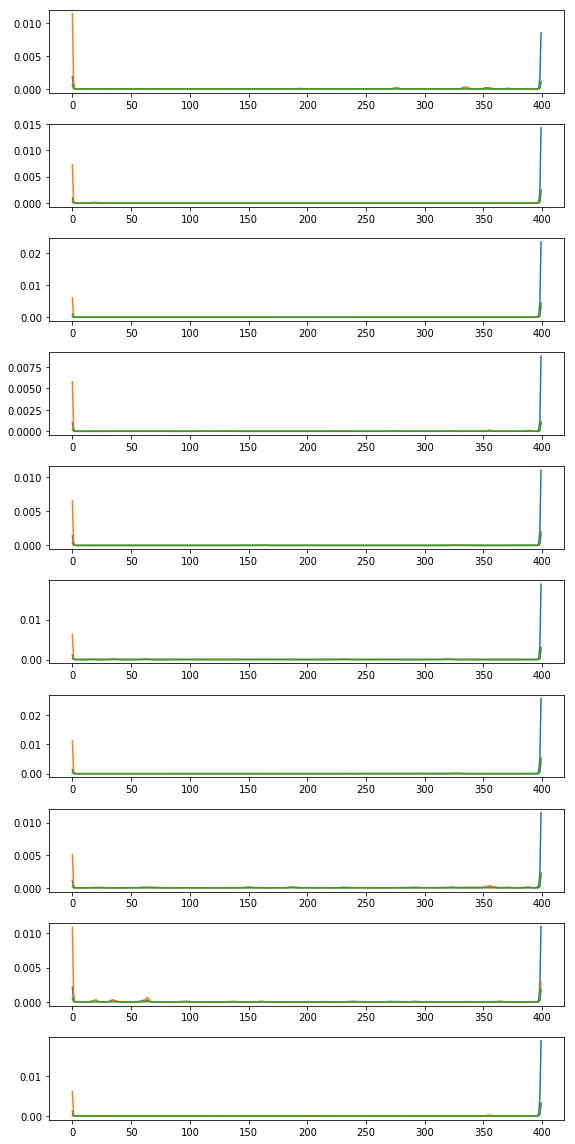

In [235]:
visual_eval_generator(g_model)

## transposed convolution

In [100]:
b = numpy.array([[1,2],[3,4]])
b = numpy.reshape(b, (4,1))
b

array([[1],
       [2],
       [3],
       [4]])

In [101]:
a = numpy.array([[1,2,3],[5,6,7],[9,10,11]])
a = numpy.reshape(a, (9,1))
a

array([[ 1],
       [ 2],
       [ 3],
       [ 5],
       [ 6],
       [ 7],
       [ 9],
       [10],
       [11]])

In [107]:
C = numpy.random.rand(4,9)
C

array([[ 0.68471452,  0.56981839,  0.83692969,  0.25676461,  0.56973693,
         0.56797416,  0.76189632,  0.65924826,  0.69705241],
       [ 0.44174768,  0.00428632,  0.70169573,  0.07567771,  0.07934489,
         0.360695  ,  0.21738237,  0.99552106,  0.11309014],
       [ 0.53514021,  0.61380851,  0.59331293,  0.14075526,  0.28489228,
         0.80878832,  0.61898631,  0.06872617,  0.91835496],
       [ 0.12782431,  0.40898952,  0.09951314,  0.31719279,  0.76418413,
         0.25736243,  0.1372523 ,  0.3749337 ,  0.4205583 ]])

In [111]:
B = numpy.dot(C,a)

In [113]:
C.T

array([[ 0.68471452,  0.44174768,  0.53514021,  0.12782431],
       [ 0.56981839,  0.00428632,  0.61380851,  0.40898952],
       [ 0.83692969,  0.70169573,  0.59331293,  0.09951314],
       [ 0.25676461,  0.07567771,  0.14075526,  0.31719279],
       [ 0.56973693,  0.07934489,  0.28489228,  0.76418413],
       [ 0.56797416,  0.360695  ,  0.80878832,  0.25736243],
       [ 0.76189632,  0.21738237,  0.61898631,  0.1372523 ],
       [ 0.65924826,  0.99552106,  0.06872617,  0.3749337 ],
       [ 0.69705241,  0.11309014,  0.91835496,  0.4205583 ]])

In [112]:
numpy.dot(C.T,B)

array([[ 49.18112324],
       [ 44.40300667],
       [ 60.43326903],
       [ 20.11815096],
       [ 43.31840234],
       [ 53.74427379],
       [ 50.05544793],
       [ 50.48714703],
       [ 59.56087876]])